## Data Analysis and Visualization

This notebook is for Data Analysis and Visualization to compare Drone Flight Data (GROUND TRUTH) and Tracking Data

## Imports

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os

## Paths and Configuration

In [ ]:
# Hardcoded paths and configuration
FLIGHT_CSV_PATH = "data/airdata/Jul-25th-2025-11-05AM-Flight-Airdata.csv"
STEREO_CSV_PATH = "data/tracking/tracking_20250727_190308/track.csv"

# BEV visualization settings
BEV_SIZE = [600, 960]  # [width, height] in pixels
BEV_SCALE = 20  # pixels per meter
ROTATION_DEGREES = 296.6  # clockwise rotation in degrees

# Time synchronization settings
TIME_RESOLUTION_MS = 100  # milliseconds for interpolation

print("Configuration loaded:")
print(f"Flight CSV: {FLIGHT_CSV_PATH}")
print(f"Stereo CSV: {STEREO_CSV_PATH}")
print(f"BEV size: {BEV_SIZE}")
print(f"BEV scale: {BEV_SCALE} pixels/meter")
print(f"Rotation: {ROTATION_DEGREES} degrees")

Configuration loaded:
Flight CSV: data/airdata/Jul-25th-2025-11-05AM-Flight-Airdata.csv
Stereo CSV: data/tracking/tracking_20250727_190308/track.csv
BEV size: [600, 960]
BEV scale: 20 pixels/meter
Rotation: 296.7 degrees


## Utility Functions

In [66]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the great circle distance between two points on Earth (in meters)."""
    R = 6371000  # Earth's radius in meters
    
    lat1_rad = math.radians(lat1)
    lat2_rad = math.radians(lat2)
    delta_lat = math.radians(lat2 - lat1)
    delta_lon = math.radians(lon2 - lon1)
    
    a = (math.sin(delta_lat/2) * math.sin(delta_lat/2) +
         math.cos(lat1_rad) * math.cos(lat2_rad) *
         math.sin(delta_lon/2) * math.sin(delta_lon/2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    
    return R * c


def gps_to_local(lat, lon, origin_lat, origin_lon):
    """Convert GPS coordinates to local X, Z coordinates."""
    # Calculate X (East-West) displacement
    x = haversine_distance(origin_lat, origin_lon, origin_lat, lon)
    if lon < origin_lon:
        x = -x
    
    # Calculate Z (North-South) displacement  
    z = haversine_distance(origin_lat, origin_lon, lat, origin_lon)
    if lat < origin_lat:
        z = -z
    
    return x, z


def rotate_coordinates(x, z, rotation_degrees):
    """Rotate coordinates by the specified angle (clockwise)."""
    angle_rad = math.radians(rotation_degrees)
    
    # Rotation matrix (clockwise)
    cos_a = math.cos(angle_rad)
    sin_a = math.sin(angle_rad)
    
    rotated_x = x * cos_a + z * sin_a
    rotated_z = -x * sin_a + z * cos_a
    
    return rotated_x, rotated_z


print("Utility functions defined successfully")

Utility functions defined successfully


## Data Loading and Processing

In [67]:
# Load flight data
print(f"Loading flight data from: {FLIGHT_CSV_PATH}")
flight_df = pd.read_csv(FLIGHT_CSV_PATH)
print(f"Loaded {len(flight_df)} flight data points")

# Check required columns
required_cols = ['latitude', 'longitude', 'datetime(utc)']
missing_cols = [col for col in required_cols if col not in flight_df.columns]
if missing_cols:
    raise ValueError(f"Missing columns: {missing_cols}")

# Check if time column exists
if 'time(millisecond)' in flight_df.columns:
    print(f"Flight time range: {flight_df['time(millisecond)'].min()}ms to {flight_df['time(millisecond)'].max()}ms")
    has_time_data = True
else:
    has_time_data = False
    print("No time data available in flight data")

# Filter out invalid GPS coordinates
flight_df = flight_df.dropna(subset=['latitude', 'longitude'])
flight_df = flight_df[(flight_df['latitude'] != 0) & (flight_df['longitude'] != 0)]

print(f"Valid GPS points: {len(flight_df)}")
print(f"Flight data columns: {list(flight_df.columns)}")
flight_df.head()

Loading flight data from: data/airdata/Jul-25th-2025-11-05AM-Flight-Airdata.csv
Loaded 1005 flight data points
Flight time range: 230100ms to 330400ms
Valid GPS points: 1005
Flight data columns: ['time(millisecond)', 'datetime(utc)', 'latitude', 'longitude', 'height_above_takeoff(feet)', 'height_above_ground_at_drone_location(feet)', 'ground_elevation_at_drone_location(feet)', 'altitude_above_seaLevel(feet)', 'height_sonar(feet)', 'speed(mph)', 'distance(feet)', 'mileage(feet)', 'satellites', 'gpslevel', 'voltage(v)', 'max_altitude(feet)', 'max_ascent(feet)', 'max_speed(mph)', 'max_distance(feet)', ' xSpeed(mph)', ' ySpeed(mph)', ' zSpeed(mph)', ' compass_heading(degrees)', ' pitch(degrees)', ' roll(degrees)', 'isPhoto', 'isVideo', 'rc_elevator', 'rc_aileron', 'rc_throttle', 'rc_rudder', 'rc_elevator(percent)', 'rc_aileron(percent)', 'rc_throttle(percent)', 'rc_rudder(percent)', 'gimbal_heading(degrees)', 'gimbal_pitch(degrees)', 'gimbal_roll(degrees)', 'battery_percent', 'voltageCell1

,time(millisecond),datetime(utc),latitude,longitude,height_above_takeoff(feet),height_above_ground_at_drone_location(feet),ground_elevation_at_drone_location(feet),altitude_above_seaLevel(feet),height_sonar(feet),speed(mph),...,voltageCell4,voltageCell5,voltageCell6,current(A),battery_temperature(f),altitude(feet),ascent(feet),flycStateRaw,flycState,message
0,230100,2025-07-25 04:05:28,-6.880775,107.454982,0.0,Available with any HD 360 subscription,Available with any HD 360 subscription,2120.626322,0.656168,0.0,...,0,0,0,0.0,115.16,2120.626322,0.0,6,P-GPS,Dalam penerbangan... Pesawat dalam Zona Keting...
1,230200,2025-07-25 04:05:28,-6.880775,107.454982,0.0,NaN,NaN,2120.626322,0.656168,0.0,...,0,0,0,0.0,115.16,2120.626322,0.0,41,Motors_Started,NaN
2,230300,2025-07-25 04:05:28,-6.880775,107.454982,0.0,NaN,NaN,2120.626322,0.328084,0.0,...,0,0,0,0.0,115.16,2120.626322,0.0,41,Motors_Started,NaN
3,230400,2025-07-25 04:05:28,-6.880775,107.454982,0.0,NaN,NaN,2120.626322,0.328084,0.0,...,0,0,0,0.0,115.16,2120.626322,0.0,41,Motors_Started,NaN
4,230500,2025-07-25 04:05:28,-6.880775,107.454982,0.0,NaN,NaN,2120.626322,0.328084,0.0,...,0,0,0,0.0,115.16,2120.626322,0.0,41,Motors_Started,NaN


In [68]:
# Load stereo data
print(f"Loading stereo data from: {STEREO_CSV_PATH}")
if not os.path.exists(STEREO_CSV_PATH):
    raise FileNotFoundError(f"Stereo data file not found: {STEREO_CSV_PATH}")

stereo_df = pd.read_csv(STEREO_CSV_PATH)
print(f"Loaded {len(stereo_df)} stereo tracking points")

# Check if time column exists
if 'time(millisecond)' in stereo_df.columns:
    print(f"Stereo time range: {stereo_df['time(millisecond)'].min()}ms to {stereo_df['time(millisecond)'].max()}ms")
    stereo_has_time = True
else:
    stereo_has_time = False
    print("No time data available in stereo data")

print(f"Stereo data columns: {list(stereo_df.columns)}")
stereo_df.head()

Loading stereo data from: data/tracking/tracking_20250727_190308/track.csv
Loaded 930 stereo tracking points
Stereo time range: 0ms to 99700ms
Stereo data columns: ['time(millisecond)', 'datetime', 'track_id', 'X', 'Y', 'Z', 'disparity']


,time(millisecond),datetime,track_id,X,Y,Z,disparity
0,0,2025-07-27 19:03:08.132,1,0.535636,1.162626,4.803103,377.250000
1,100,2025-07-27 19:03:08.232,1,0.533177,1.163596,4.800507,377.454010
2,200,2025-07-27 19:03:08.332,1,0.534587,1.164863,4.812289,376.529846
3,300,2025-07-27 19:03:08.432,1,0.534890,1.156897,4.779455,379.116516
4,400,2025-07-27 19:03:08.532,1,0.535656,1.162139,4.801106,377.406921


In [69]:
# Process flight data to local coordinates
origin_lat = flight_df.iloc[0]['latitude']
origin_lon = flight_df.iloc[0]['longitude']

print(f"GPS Origin: lat={origin_lat:.8f}, lon={origin_lon:.8f}")
print(f"Applying rotation: {ROTATION_DEGREES} degrees")

# Convert flight GPS to local coordinates with rotation
flight_coords_raw = []
flight_coords_no_rotation = []
flight_coords_with_offset = []

for _, row in flight_df.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    # Convert to local coordinates
    x, z = gps_to_local(lat, lon, origin_lat, origin_lon)
    flight_coords_no_rotation.append((x, z))

    x, z = rotate_coordinates(x, z, ROTATION_DEGREES)
    flight_coords_raw.append((x, z))

print(f"Processed {len(flight_coords_raw)} flight coordinates")

# Extract stereo coordinates
stereo_coords = [(row['X'], row['Z']) for _, row in stereo_df.iterrows()]
print(f"Extracted {len(stereo_coords)} stereo coordinates")

# Apply offset to align starting positions (drone vs camera offset)
if len(stereo_coords) > 0 and len(flight_coords_raw) > 0:
    stereo_start_x, stereo_start_z = stereo_coords[0]
    flight_start_x, flight_start_z = flight_coords_raw[0]
    offset_x = stereo_start_x - flight_start_x
    offset_z = stereo_start_z - flight_start_z
    
    flight_coords_with_offset = [(x + offset_x, z + offset_z) for x, z in flight_coords_raw]
    
    print(f"Before offset - Flight start: X={flight_start_x:.3f}, Z={flight_start_z:.3f}")
    print(f"Before offset - Stereo start: X={stereo_start_x:.3f}, Z={stereo_start_z:.3f}")
    print(f"Applied offset: X={offset_x:.3f}m, Z={offset_z:.3f}m")
    print(f"After offset - Flight start: X={flight_coords_with_offset[0][0]:.3f}, Z={flight_coords_with_offset[0][1]:.3f}")

# Use offset coordinates for final comparison
flight_coords_aligned = flight_coords_with_offset

GPS Origin: lat=-6.88077493, lon=107.45498189
Applying rotation: 296.7 degrees
Processed 1005 flight coordinates
Extracted 930 stereo coordinates
Before offset - Flight start: X=0.000, Z=0.000
Before offset - Stereo start: X=0.536, Z=4.803
Applied offset: X=0.536m, Z=4.803m
After offset - Flight start: X=0.536, Z=4.803


In [70]:
# Time-based synchronization (if both datasets have time data)
if has_time_data and stereo_has_time:
    print("Performing improved time-based synchronization...")
    
    # Get raw timestamps
    flight_start_time = flight_df['time(millisecond)'].min()
    stereo_start_time = stereo_df['time(millisecond)'].min()
    
    # Find the time offset between datasets (which one starts first)
    time_offset_ms = stereo_start_time - flight_start_time
    print(f"Flight start time: {flight_start_time}ms")
    print(f"Stereo start time: {stereo_start_time}ms")
    print(f"Time offset: {time_offset_ms}ms (positive means stereo starts after flight)")
    
    # If there's no temporal overlap, use the original coordinate-based approach
    # but first check if we can align them by assuming they represent the same time period
    flight_duration = (flight_df['time(millisecond)'].max() - flight_df['time(millisecond)'].min()) / 1000
    stereo_duration = (stereo_df['time(millisecond)'].max() - stereo_df['time(millisecond)'].min()) / 1000
    
    print(f"Flight duration: {flight_duration:.1f}s")
    print(f"Stereo duration: {stereo_duration:.1f}s")
    
    # Check if durations are similar (within 20% difference) - suggesting they might be the same time period
    duration_ratio = min(flight_duration, stereo_duration) / max(flight_duration, stereo_duration)
    
    if duration_ratio > 0.8:  # Similar durations, likely same time period with different start times
        print(f"Similar durations detected (ratio: {duration_ratio:.2f}), performing advanced time alignment...")
        
        # Use relative time within each dataset (0 to duration)
        flight_time_rel = (flight_df['time(millisecond)'] - flight_df['time(millisecond)'].min()) / 1000
        stereo_time_rel = (stereo_df['time(millisecond)'] - stereo_df['time(millisecond)'].min()) / 1000
        
        # Prepare data for cross-correlation analysis
        flight_x_aligned = [coord[0] for coord in flight_coords_aligned]
        flight_z_aligned = [coord[1] for coord in flight_coords_aligned]
        
        # Create uniform time grids for both datasets for cross-correlation
        common_dt = 0.5  # Use 0.5s resolution for cross-correlation
        max_duration = max(flight_duration, stereo_duration)
        common_time = np.arange(0, max_duration, common_dt)
        
        # Interpolate both datasets to common time grid
        flight_x_common = np.interp(common_time, flight_time_rel, flight_x_aligned)
        flight_z_common = np.interp(common_time, flight_time_rel, flight_z_aligned)
        stereo_x_common = np.interp(common_time, stereo_time_rel, stereo_df['X'])
        stereo_z_common = np.interp(common_time, stereo_time_rel, stereo_df['Z'])
        
        # Calculate velocity for cross-correlation (more distinctive feature)
        flight_vel_common = np.sqrt(np.diff(flight_x_common)**2 + np.diff(flight_z_common)**2)
        stereo_vel_common = np.sqrt(np.diff(stereo_x_common)**2 + np.diff(stereo_z_common)**2)
        
        # Normalize velocities for better correlation
        flight_vel_norm = (flight_vel_common - np.mean(flight_vel_common)) / (np.std(flight_vel_common) + 1e-8)
        stereo_vel_norm = (stereo_vel_common - np.mean(stereo_vel_common)) / (np.std(stereo_vel_common) + 1e-8)
        
        # Perform cross-correlation to find optimal time offset
        correlation = np.correlate(flight_vel_norm, stereo_vel_norm, mode='full')
        max_corr_idx = np.argmax(correlation)
        
        # Calculate optimal time offset
        optimal_offset = (max_corr_idx - len(stereo_vel_norm) + 1) * common_dt
        print(f"Cross-correlation analysis:")
        print(f"Optimal time offset: {optimal_offset:.2f}s (positive means stereo leads flight)")
        print(f"Maximum correlation: {correlation[max_corr_idx]:.3f}")
        
        # Apply optimal offset - if stereo leads (positive offset), delay stereo data
        if optimal_offset > 0:
            # Stereo leads, so delay stereo relative time
            stereo_time_aligned = stereo_time_rel + optimal_offset
            flight_time_aligned = flight_time_rel
        else:
            # Flight leads, so delay flight relative time
            flight_time_aligned = flight_time_rel + abs(optimal_offset)
            stereo_time_aligned = stereo_time_rel
        
        # Find common time range after alignment
        start_time = max(flight_time_aligned.min(), stereo_time_aligned.min())
        end_time = min(flight_time_aligned.max(), stereo_time_aligned.max())
        sync_duration = end_time - start_time
        
        if sync_duration > 5:  # Only proceed if we have at least 5 seconds of overlap
            timestamps_sec = np.arange(start_time, end_time + TIME_RESOLUTION_MS/1000, TIME_RESOLUTION_MS/1000)
            
            # Filter data within the aligned time range
            flight_mask = (flight_time_aligned >= start_time) & (flight_time_aligned <= end_time)
            stereo_mask = (stereo_time_aligned >= start_time) & (stereo_time_aligned <= end_time)
            
            flight_time_sync = flight_time_aligned[flight_mask]
            flight_x_sync = np.array(flight_x_aligned)[flight_mask]
            flight_z_sync = np.array(flight_z_aligned)[flight_mask]
            
            stereo_time_sync = stereo_time_aligned[stereo_mask]
            stereo_x_sync = stereo_df['X'][stereo_mask]
            stereo_z_sync = stereo_df['Z'][stereo_mask]
            
            print(f"After alignment - sync duration: {sync_duration:.1f}s with {len(timestamps_sec)} points")
            print(f"Flight points in sync period: {len(flight_time_sync)}")
            print(f"Stereo points in sync period: {len(stereo_time_sync)}")
            
            # Interpolate both datasets to common time base
            flight_x_interp = np.interp(timestamps_sec, flight_time_sync, flight_x_sync)
            flight_z_interp = np.interp(timestamps_sec, flight_time_sync, flight_z_sync)
            stereo_x_interp = np.interp(timestamps_sec, stereo_time_sync, stereo_x_sync)
            stereo_z_interp = np.interp(timestamps_sec, stereo_time_sync, stereo_z_sync)
            
            # Apply additional spatial offset after time alignment
            print(f"Before spatial offset - Flight start: X={flight_x_interp[0]:.3f}, Z={flight_z_interp[0]:.3f}")
            print(f"Before spatial offset - Stereo start: X={stereo_x_interp[0]:.3f}, Z={stereo_z_interp[0]:.3f}")
            
            post_offset_x = stereo_x_interp[0] - flight_x_interp[0]
            post_offset_z = stereo_z_interp[0] - flight_z_interp[0]
            
            flight_x_interp += post_offset_x
            flight_z_interp += post_offset_z
            
            print(f"Applied spatial offset: X={post_offset_x:.3f}m, Z={post_offset_z:.3f}m")
            print(f"After spatial offset - Flight start: X={flight_x_interp[0]:.3f}, Z={flight_z_interp[0]:.3f}")
            
            # Create synchronized coordinate lists
            flight_coords_sync = list(zip(flight_x_interp, flight_z_interp))
            stereo_coords_sync = list(zip(stereo_x_interp, stereo_z_interp))
            
            comparison_duration = sync_duration
        else:
            print(f"Insufficient overlap after alignment ({sync_duration:.1f}s), falling back to original method")
            # Fall back to original method
            sync_duration = min(flight_duration, stereo_duration)
            timestamps_sec = np.arange(0, sync_duration + TIME_RESOLUTION_MS/1000, TIME_RESOLUTION_MS/1000)
            
            flight_mask = flight_time_rel <= sync_duration
            stereo_mask = stereo_time_rel <= sync_duration
            
            flight_time_sync = flight_time_rel[flight_mask]
            flight_x_sync = np.array(flight_x_aligned)[flight_mask]
            flight_z_sync = np.array(flight_z_aligned)[flight_mask]
            
            stereo_time_sync = stereo_time_rel[stereo_mask]
            stereo_x_sync = stereo_df['X'][stereo_mask]
            stereo_z_sync = stereo_df['Z'][stereo_mask]
            
            flight_x_interp = np.interp(timestamps_sec, flight_time_sync, flight_x_sync)
            flight_z_interp = np.interp(timestamps_sec, flight_time_sync, flight_z_sync)
            stereo_x_interp = np.interp(timestamps_sec, stereo_time_sync, stereo_x_sync)
            stereo_z_interp = np.interp(timestamps_sec, stereo_time_sync, stereo_z_sync)
            
            post_offset_x = stereo_x_interp[0] - flight_x_interp[0]
            post_offset_z = stereo_z_interp[0] - flight_z_interp[0]
            flight_x_interp += post_offset_x
            flight_z_interp += post_offset_z
            
            flight_coords_sync = list(zip(flight_x_interp, flight_z_interp))
            stereo_coords_sync = list(zip(stereo_x_interp, stereo_z_interp))
            comparison_duration = sync_duration
        
    else:
        print(f"Different durations (ratio: {duration_ratio:.2f}), using coordinate-based alignment...")
        # Fall back to coordinate-based synchronization
        flight_coords_sync = flight_coords_aligned
        stereo_coords_sync = stereo_coords
        timestamps_sec = None
        comparison_duration = 0
    
    print(f"Synchronized {len(timestamps_sec)} points over {comparison_duration:.1f}s")
    
else:
    print("Using coordinate-only comparison (no time synchronization)")
    flight_coords_sync = flight_coords_aligned
    stereo_coords_sync = stereo_coords
    timestamps_sec = None

Performing improved time-based synchronization...
Flight start time: 230100ms
Stereo start time: 0ms
Time offset: -230100ms (positive means stereo starts after flight)
Flight duration: 100.3s
Stereo duration: 99.7s
Similar durations detected (ratio: 0.99), performing advanced time alignment...
Cross-correlation analysis:
Optimal time offset: 0.50s (positive means stereo leads flight)
Maximum correlation: 139.196
After alignment - sync duration: 99.7s with 998 points
Flight points in sync period: 998
Stereo points in sync period: 930
Before spatial offset - Flight start: X=0.546, Z=4.798
Before spatial offset - Stereo start: X=0.536, Z=4.803
Applied spatial offset: X=-0.010m, Z=0.005m
After spatial offset - Flight start: X=0.536, Z=4.803
Synchronized 998 points over 99.7s


# Data Visualization

## 1. Separate Tracking vs Ground Truth Visualization

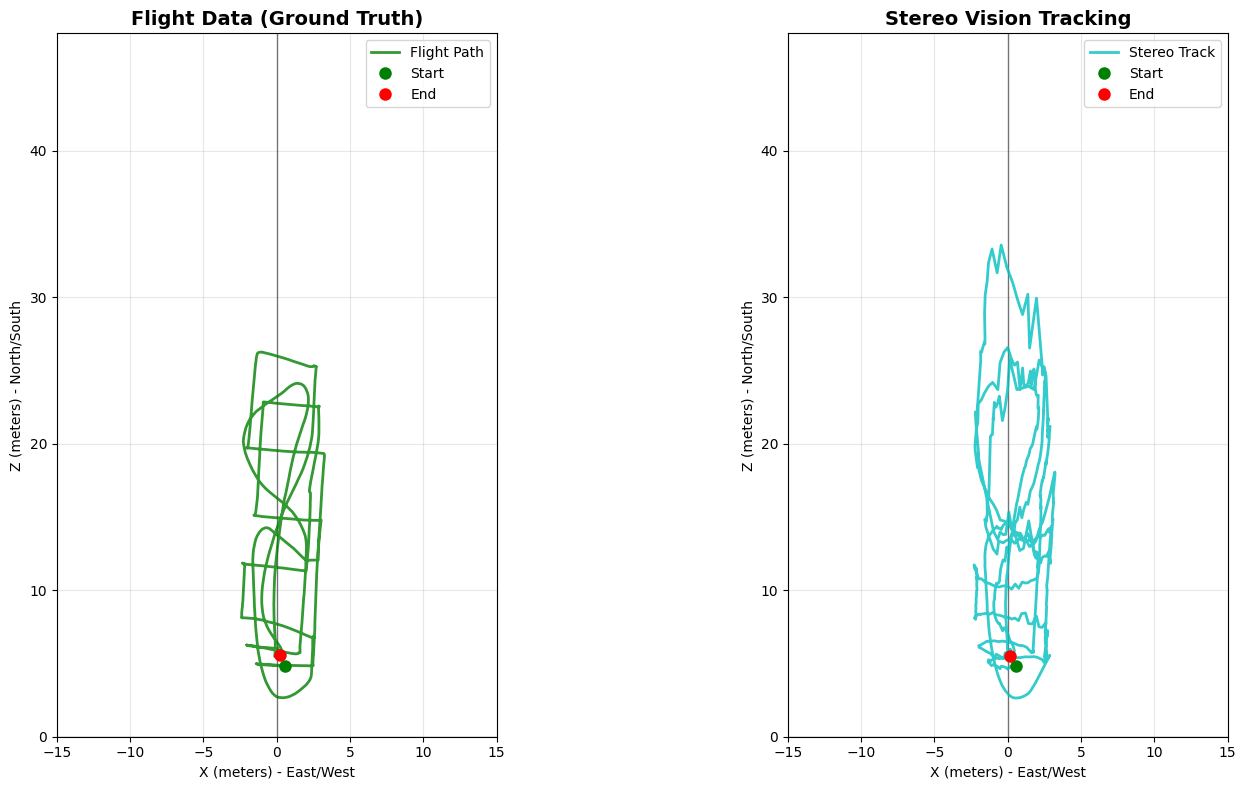

In [71]:
# Create separate plots for Flight Data and Stereo Tracking
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Calculate plot dimensions in meters
width_meters = BEV_SIZE[0] / BEV_SCALE
height_meters = BEV_SIZE[1] / BEV_SCALE

# Set plot limits (origin at bottom center)
x_min, x_max = -width_meters / 2, width_meters / 2
z_min, z_max = 0, height_meters

for ax in [ax1, ax2]:
    ax.set_aspect('equal')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(z_min, z_max)
    ax.grid(True, alpha=0.3)
    ax.axvline(0, color='black', linewidth=1, alpha=0.5)
    ax.axhline(0, color='black', linewidth=1, alpha=0.5)

# Plot Flight Data (Ground Truth)
if flight_coords_sync:
    flight_x = [coord[0] for coord in flight_coords_sync]
    flight_z = [coord[1] for coord in flight_coords_sync]
    ax1.plot(flight_x, flight_z, 'g-', linewidth=2, label='Flight Path', alpha=0.8)
    ax1.plot(flight_x[0], flight_z[0], 'go', markersize=8, label='Start')
    ax1.plot(flight_x[-1], flight_z[-1], 'ro', markersize=8, label='End')

ax1.set_title('Flight Data (Ground Truth)', fontsize=14, fontweight='bold')
ax1.set_xlabel('X (meters) - East/West')
ax1.set_ylabel('Z (meters) - North/South')
ax1.legend()

# Plot Stereo Tracking Data
if stereo_coords_sync:
    stereo_x = [coord[0] for coord in stereo_coords_sync]
    stereo_z = [coord[1] for coord in stereo_coords_sync]
    ax2.plot(stereo_x, stereo_z, 'c-', linewidth=2, label='Stereo Track', alpha=0.8)
    ax2.plot(stereo_x[0], stereo_z[0], 'go', markersize=8, label='Start')
    ax2.plot(stereo_x[-1], stereo_z[-1], 'ro', markersize=8, label='End')

ax2.set_title('Stereo Vision Tracking', fontsize=14, fontweight='bold')
ax2.set_xlabel('X (meters) - East/West')
ax2.set_ylabel('Z (meters) - North/South')
ax2.legend()

plt.tight_layout()
plt.show()

## 2. Combined Comparison Visualization

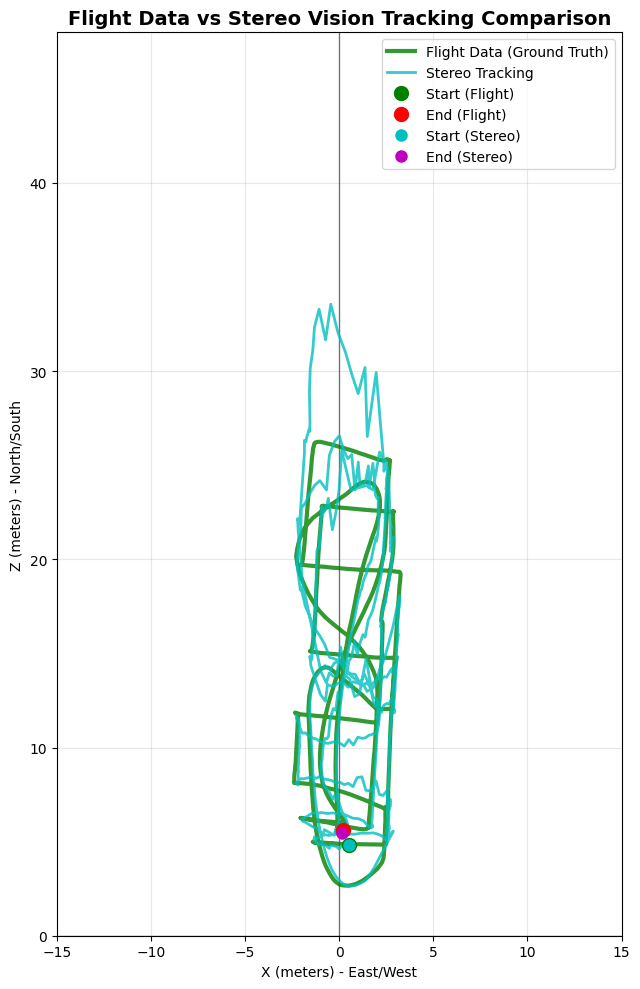

In [72]:
# Combined comparison plot
fig, ax = plt.subplots(figsize=(12, 10))

# Set up the plot with same dimensions as before
ax.set_aspect('equal')
ax.set_xlim(x_min, x_max)
ax.set_ylim(z_min, z_max)
ax.grid(True, alpha=0.3)
ax.axvline(0, color='black', linewidth=1, alpha=0.5)
ax.axhline(0, color='black', linewidth=1, alpha=0.5)

# Plot both datasets
if flight_coords_sync:
    flight_x = [coord[0] for coord in flight_coords_sync]
    flight_z = [coord[1] for coord in flight_coords_sync]
    ax.plot(flight_x, flight_z, 'g-', linewidth=3, label='Flight Data (Ground Truth)', alpha=0.8)

if stereo_coords_sync:
    stereo_x = [coord[0] for coord in stereo_coords_sync]
    stereo_z = [coord[1] for coord in stereo_coords_sync]
    ax.plot(stereo_x, stereo_z, 'c-', linewidth=2, label='Stereo Tracking', alpha=0.8)

# Mark start and end points
if flight_coords_sync:
    ax.plot(flight_x[0], flight_z[0], 'go', markersize=10, label='Start (Flight)', zorder=5)
    ax.plot(flight_x[-1], flight_z[-1], 'ro', markersize=10, label='End (Flight)', zorder=5)

if stereo_coords_sync:
    ax.plot(stereo_x[0], stereo_z[0], 'co', markersize=8, label='Start (Stereo)', zorder=5)
    ax.plot(stereo_x[-1], stereo_z[-1], 'mo', markersize=8, label='End (Stereo)', zorder=5)

ax.set_title('Flight Data vs Stereo Vision Tracking Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('X (meters) - East/West')
ax.set_ylabel('Z (meters) - North/South')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 3. Distance from Origin Over Time

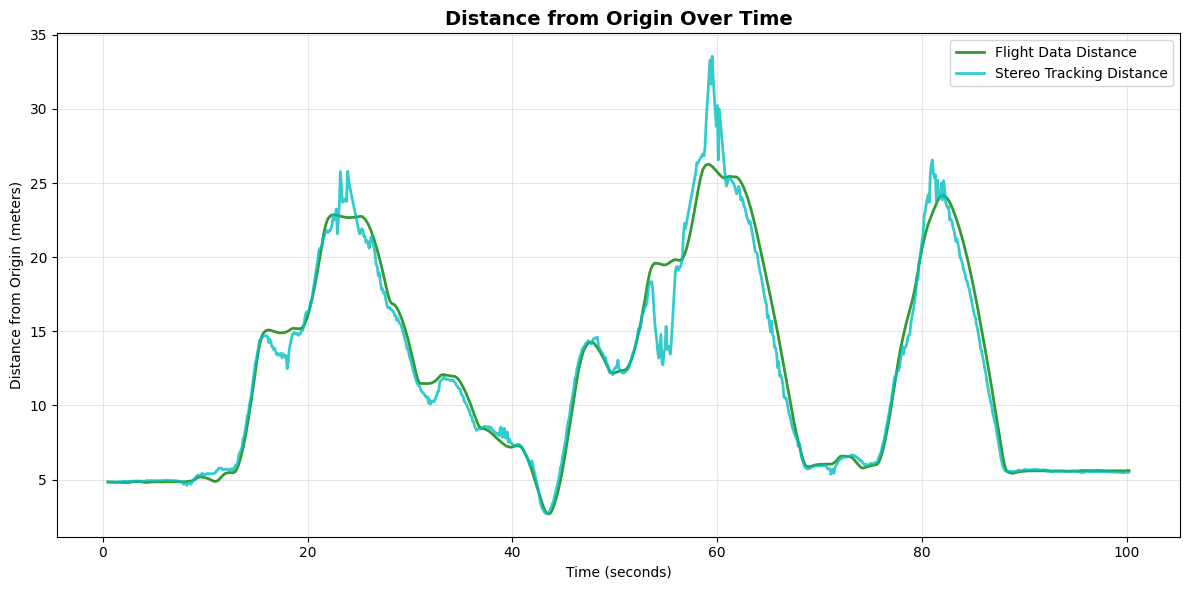

In [73]:
# Calculate distance from origin for both datasets
if flight_coords_sync:
    flight_dist_origin = [np.sqrt(x**2 + z**2) for x, z in flight_coords_sync]

if stereo_coords_sync:
    stereo_dist_origin = [np.sqrt(x**2 + z**2) for x, z in stereo_coords_sync]

# Create time axis
if timestamps_sec is not None:
    time_axis = timestamps_sec
    time_label = "Time (seconds)"
else:
    # Create artificial time axis based on data points
    time_axis = np.linspace(0, len(flight_coords_sync) * 0.1, len(flight_coords_sync))
    time_label = "Time (arbitrary units)"

# Plot distance over time
fig, ax = plt.subplots(figsize=(12, 6))

if flight_coords_sync:
    ax.plot(time_axis[:len(flight_dist_origin)], flight_dist_origin, 'g-', linewidth=2, 
            label='Flight Data Distance', alpha=0.8)

if stereo_coords_sync:
    ax.plot(time_axis[:len(stereo_dist_origin)], stereo_dist_origin, 'c-', linewidth=2, 
            label='Stereo Tracking Distance', alpha=0.8)

ax.set_title('Distance from Origin Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel(time_label)
ax.set_ylabel('Distance from Origin (meters)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 4. X Position Over Time

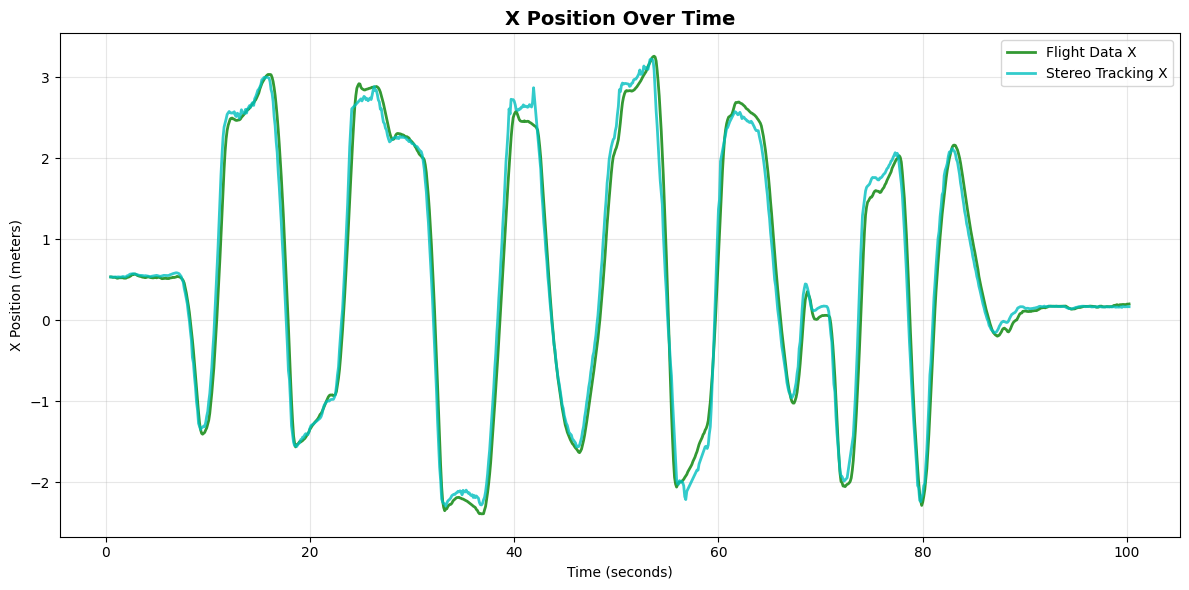

In [74]:
# Plot X position over time
if flight_coords_sync:
    flight_x_over_time = [x for x, _ in flight_coords_sync]

if stereo_coords_sync:
    stereo_x_over_time = [x for x, _ in stereo_coords_sync]

fig, ax = plt.subplots(figsize=(12, 6))

if flight_coords_sync:
    ax.plot(time_axis[:len(flight_x_over_time)], flight_x_over_time, 'g-', linewidth=2,
            label='Flight Data X', alpha=0.8)

if stereo_coords_sync:
    ax.plot(time_axis[:len(stereo_x_over_time)], stereo_x_over_time, 'c-', linewidth=2,
            label='Stereo Tracking X', alpha=0.8)

ax.set_title('X Position Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel(time_label)
ax.set_ylabel('X Position (meters)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 5. Velocity Comparison Over Time

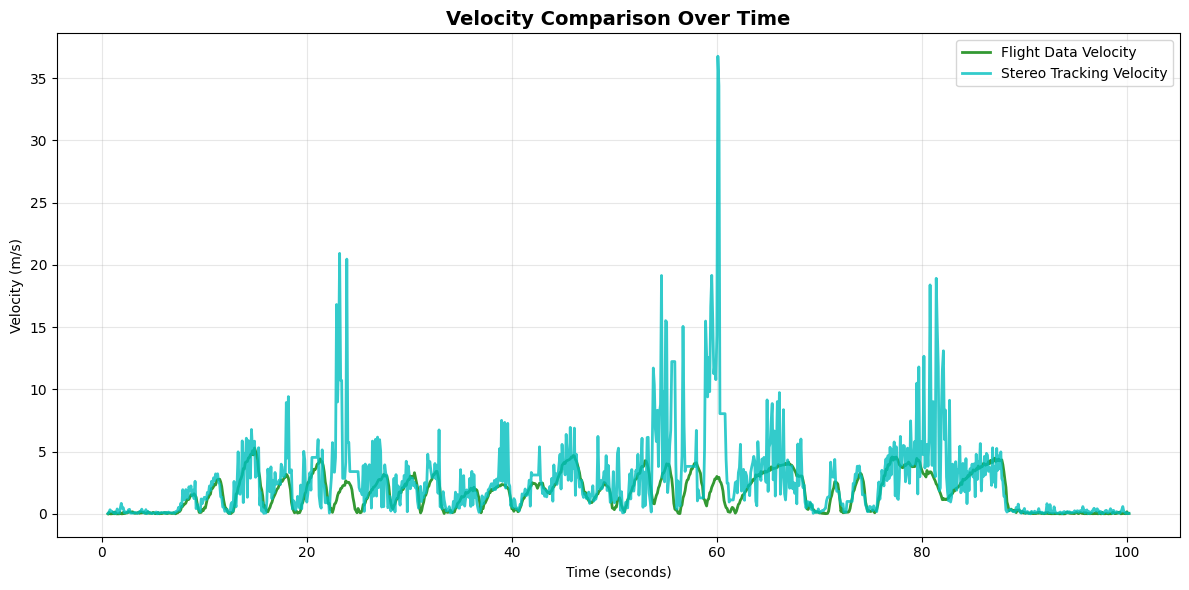

In [75]:
# Calculate velocity for both datasets
if len(flight_coords_sync) > 1:
    flight_x = [coord[0] for coord in flight_coords_sync]
    flight_z = [coord[1] for coord in flight_coords_sync]
    flight_dx = np.diff(flight_x)
    flight_dz = np.diff(flight_z)
    if timestamps_sec is not None:
        flight_dt = np.diff(timestamps_sec)
        flight_velocity = np.sqrt(flight_dx**2 + flight_dz**2) / flight_dt
    else:
        flight_velocity = np.sqrt(flight_dx**2 + flight_dz**2) / 0.1  # Assume 0.1s intervals

if len(stereo_coords_sync) > 1:
    stereo_x = [coord[0] for coord in stereo_coords_sync]
    stereo_z = [coord[1] for coord in stereo_coords_sync]
    stereo_dx = np.diff(stereo_x)
    stereo_dz = np.diff(stereo_z)
    if timestamps_sec is not None:
        stereo_dt = np.diff(timestamps_sec)
        stereo_velocity = np.sqrt(stereo_dx**2 + stereo_dz**2) / stereo_dt
    else:
        stereo_velocity = np.sqrt(stereo_dx**2 + stereo_dz**2) / 0.1  # Assume 0.1s intervals

# Plot velocity over time
fig, ax = plt.subplots(figsize=(12, 6))

# Time axis for velocity (one point less due to diff)
if timestamps_sec is not None:
    time_vel = timestamps_sec[1:]
else:
    time_vel = time_axis[1:]

if len(flight_coords_sync) > 1:
    ax.plot(time_vel[:len(flight_velocity)], flight_velocity, 'g-', linewidth=2, 
            label='Flight Data Velocity', alpha=0.8)

if len(stereo_coords_sync) > 1:
    ax.plot(time_vel[:len(stereo_velocity)], stereo_velocity, 'c-', linewidth=2, 
            label='Stereo Tracking Velocity', alpha=0.8)

ax.set_title('Velocity Comparison Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel(time_label)
ax.set_ylabel('Velocity (m/s)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## 6. Error Analysis

Error Statistics:
RMSE Total: 0.905 meters
RMSE X: 0.230 meters
RMSE Z: 1.260 meters
Average Error: 0.764 meters
Median Error: 0.438 meters
Max Error: 7.440 meters
Min Error: 0.000 meters
Error Std Dev: 1.027 meters
Total Points: 998


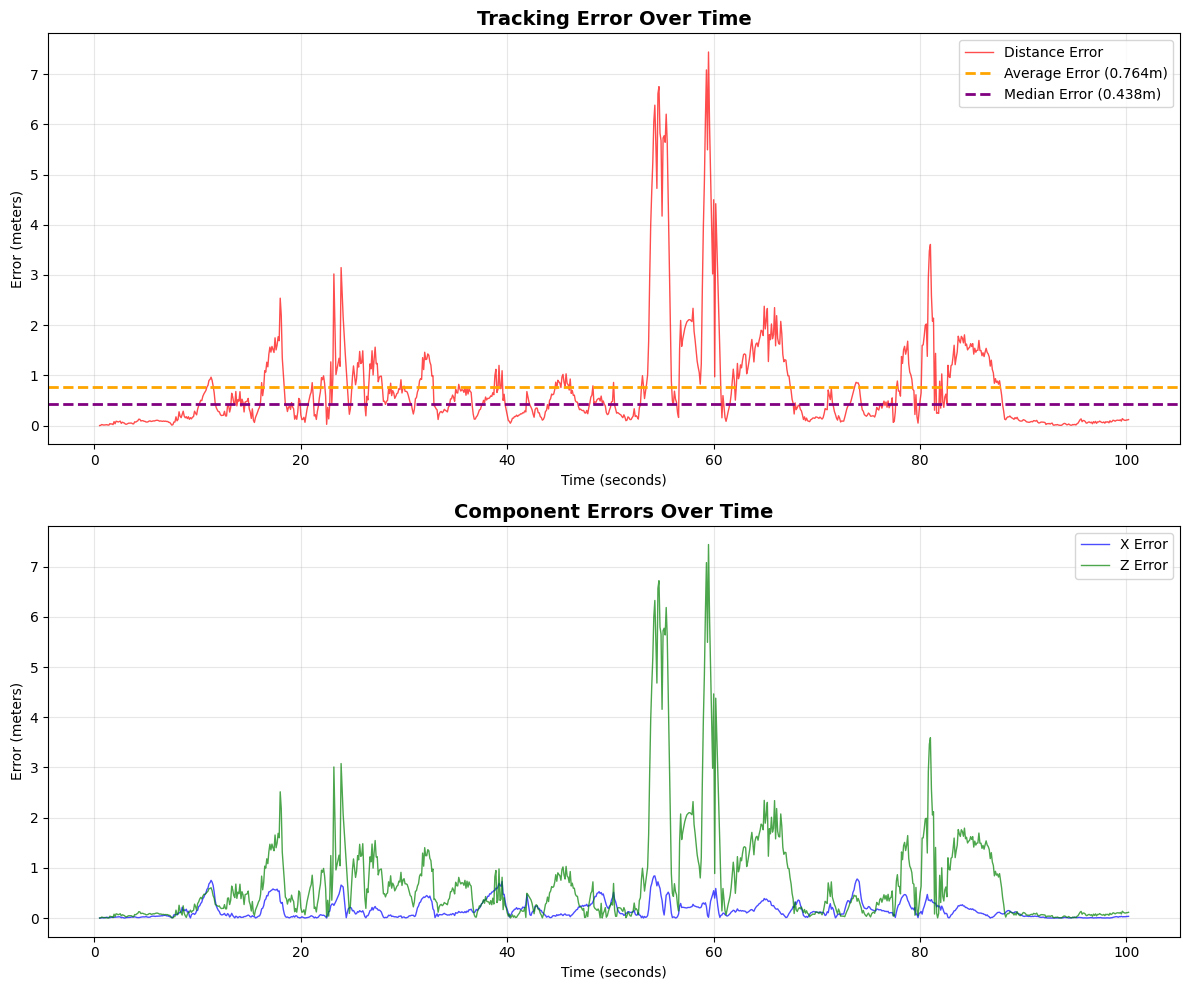

In [76]:
# Calculate errors between flight data and stereo tracking
if len(flight_coords_sync) > 0 and len(stereo_coords_sync) > 0:
    # Ensure both datasets have the same length
    min_len = min(len(flight_coords_sync), len(stereo_coords_sync))
    
    flight_x_sync = [coord[0] for coord in flight_coords_sync[:min_len]]
    flight_z_sync = [coord[1] for coord in flight_coords_sync[:min_len]]
    stereo_x_sync = [coord[0] for coord in stereo_coords_sync[:min_len]]
    stereo_z_sync = [coord[1] for coord in stereo_coords_sync[:min_len]]
    
    # Calculate errors
    x_errors = [abs(fx - sx) for fx, sx in zip(flight_x_sync, stereo_x_sync)]
    z_errors = [abs(fz - sz) for fz, sz in zip(flight_z_sync, stereo_z_sync)]
    errors = [np.sqrt((fx - sx)**2 + (fz - sz)**2) for fx, sx, fz, sz in 
              zip(flight_x_sync, stereo_x_sync, flight_z_sync, stereo_z_sync)]
    
    # Calculate RMSE using the same method as Python script
    mse_x = np.mean(np.array(x_errors)**2)
    mse_z = np.mean(np.array(z_errors)**2)
    rmse = np.sqrt((mse_x + mse_z) / 2)  # Python script method
    x_rmse = np.sqrt(mse_x)
    z_rmse = np.sqrt(mse_z)
    
    # Calculate statistics
    avg_error = np.mean(errors)
    median_error = np.median(errors)
    max_error = np.max(errors)
    min_error = np.min(errors)
    error_std = np.std(errors)
    
    print(f"Error Statistics:")
    print(f"RMSE Total: {rmse:.3f} meters")
    print(f"RMSE X: {x_rmse:.3f} meters")
    print(f"RMSE Z: {z_rmse:.3f} meters")
    print(f"Average Error: {avg_error:.3f} meters")
    print(f"Median Error: {median_error:.3f} meters")
    print(f"Max Error: {max_error:.3f} meters")
    print(f"Min Error: {min_error:.3f} meters")
    print(f"Error Std Dev: {error_std:.3f} meters")
    print(f"Total Points: {min_len}")
    
    # Plot error over time
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Time axis for error plot
    if timestamps_sec is not None:
        error_time = timestamps_sec[:min_len]
    else:
        error_time = np.linspace(0, min_len * 0.1, min_len)
    
    # Error over time
    ax1.plot(error_time, errors, 'r-', linewidth=1, alpha=0.7, label='Distance Error')
    ax1.axhline(avg_error, color='orange', linestyle='--', linewidth=2, label=f'Average Error ({avg_error:.3f}m)')
    ax1.axhline(median_error, color='purple', linestyle='--', linewidth=2, label=f'Median Error ({median_error:.3f}m)')
    ax1.set_title('Tracking Error Over Time', fontsize=14, fontweight='bold')
    ax1.set_xlabel(time_label)
    ax1.set_ylabel('Error (meters)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Component errors
    ax2.plot(error_time, x_errors, 'b-', linewidth=1, alpha=0.7, label='X Error')
    ax2.plot(error_time, z_errors, 'g-', linewidth=1, alpha=0.7, label='Z Error')
    ax2.set_title('Component Errors Over Time', fontsize=14, fontweight='bold')
    ax2.set_xlabel(time_label)
    ax2.set_ylabel('Error (meters)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Cannot calculate errors: insufficient data")

## 7. Error Distribution Analysis

C:\Users\farya\AppData\Local\Temp\ipykernel_37912\1711328209.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([errors], labels=['Distance Error'])


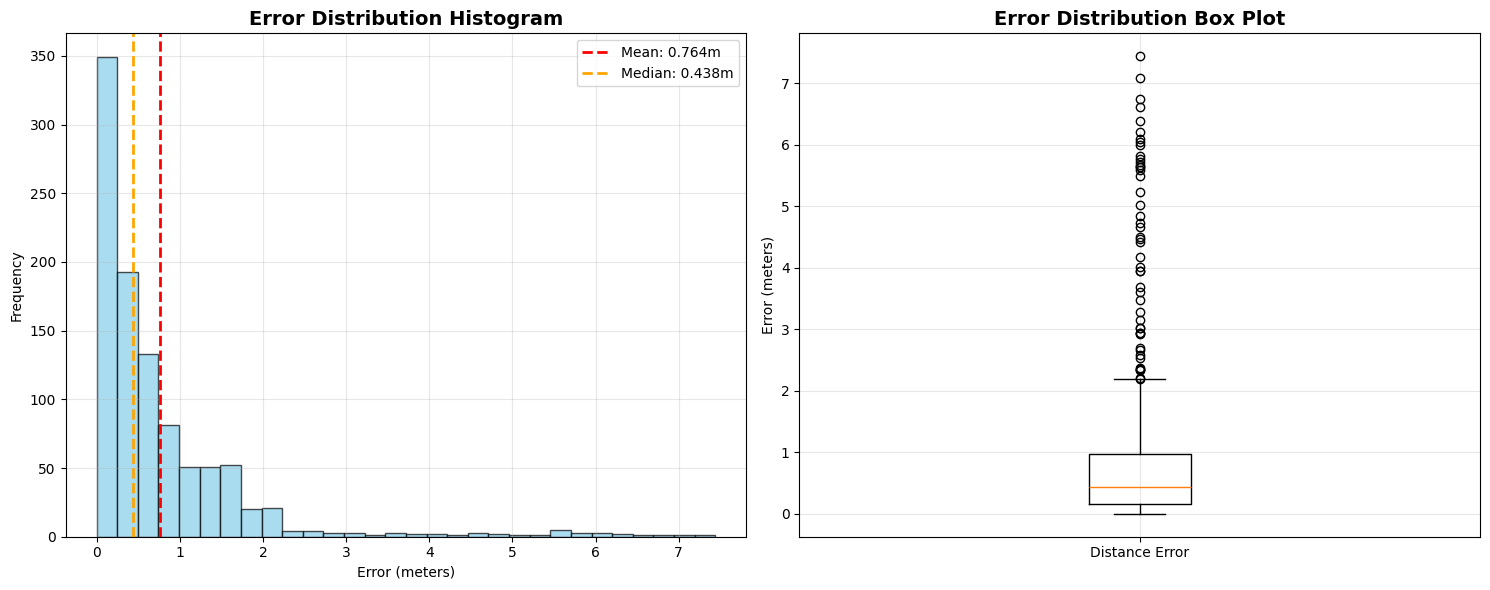


Error Percentiles:
50th percentile (median): 0.438m
90th percentile: 1.646m
95th percentile: 2.161m

Error Categories:
Excellent (≤0.5m): 543 points (54.4%)
Good (0.5m-1.0m): 215 points (21.5%)
Acceptable (1.0m-2.0m): 173 points (17.3%)
High Error (>2.0m): 67 points (6.7%)


In [77]:
# Error distribution analysis
if 'errors' in locals() and len(errors) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Error histogram
    ax1.hist(errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(avg_error, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_error:.3f}m')
    ax1.axvline(median_error, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_error:.3f}m')
    ax1.set_title('Error Distribution Histogram', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Error (meters)')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Box plot for error analysis
    ax2.boxplot([errors], labels=['Distance Error'])
    ax2.set_title('Error Distribution Box Plot', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Error (meters)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate percentiles
    p50_error = np.percentile(errors, 50)
    p90_error = np.percentile(errors, 90)
    p95_error = np.percentile(errors, 95)
    
    print(f"\nError Percentiles:")
    print(f"50th percentile (median): {p50_error:.3f}m")
    print(f"90th percentile: {p90_error:.3f}m")
    print(f"95th percentile: {p95_error:.3f}m")
    
    # Error categories
    excellent_threshold = 0.5  # meters
    good_threshold = 1.0
    acceptable_threshold = 2.0
    
    excellent_count = sum(1 for e in errors if e <= excellent_threshold)
    good_count = sum(1 for e in errors if excellent_threshold < e <= good_threshold)
    acceptable_count = sum(1 for e in errors if good_threshold < e <= acceptable_threshold)
    high_error_count = sum(1 for e in errors if e > acceptable_threshold)
    
    total_points = len(errors)
    excellent_pct = (excellent_count / total_points) * 100
    good_pct = (good_count / total_points) * 100
    acceptable_pct = (acceptable_count / total_points) * 100
    high_error_threshold = (high_error_count / total_points) * 100
    
    print(f"\nError Categories:")
    print(f"Excellent (≤{excellent_threshold}m): {excellent_count} points ({excellent_pct:.1f}%)")
    print(f"Good ({excellent_threshold}m-{good_threshold}m): {good_count} points ({good_pct:.1f}%)")
    print(f"Acceptable ({good_threshold}m-{acceptable_threshold}m): {acceptable_count} points ({acceptable_pct:.1f}%)")
    print(f"High Error (>{acceptable_threshold}m): {high_error_count} points ({high_error_threshold:.1f}%)")
    
else:
    print("No error data available for distribution analysis")

## 8. Performance Metrics Visualization

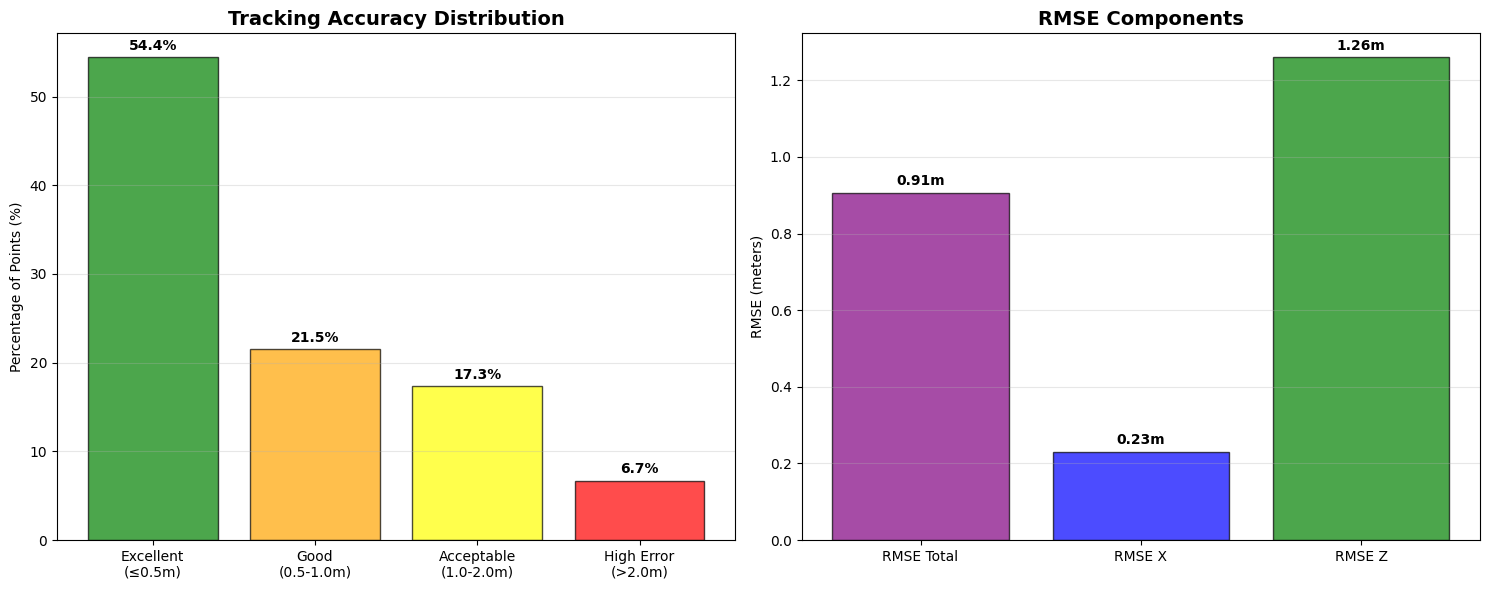


TRACKING PERFORMANCE SUMMARY
Overall Assessment: Good
Average Error: 0.764m
RMSE: 0.905m
Best Accuracy: 54.4% of points within 0.5m
Duration Analyzed: 99.7s
Total Points: 998


In [78]:
# Performance metrics visualization
if 'errors' in locals() and len(errors) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar chart of error categories
    categories = ['Excellent\n(≤0.5m)', 'Good\n(0.5-1.0m)', 'Acceptable\n(1.0-2.0m)', 'High Error\n(>2.0m)']
    values = [excellent_pct, good_pct, acceptable_pct, high_error_threshold]
    colors = ['green', 'orange', 'yellow', 'red']
    
    bars = ax1.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_title('Tracking Accuracy Distribution', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Percentage of Points (%)')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels on bars
    for bar, value in zip(bars, values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # RMSE components comparison
    rmse_components = ['RMSE Total', 'RMSE X', 'RMSE Z']
    rmse_values = [rmse, x_rmse, z_rmse] if 'rmse' in locals() else [0, 0, 0]
    
    ax2.bar(rmse_components, rmse_values, color=['purple', 'blue', 'green'], alpha=0.7, edgecolor='black')
    ax2.set_title('RMSE Components', fontsize=14, fontweight='bold')
    ax2.set_ylabel('RMSE (meters)')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, value in enumerate(rmse_values):
        ax2.text(i, value + max(rmse_values) * 0.01, f'{value:.2f}m', 
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Performance assessment
    if avg_error <= 0.5:
        assessment = "Excellent"
    elif avg_error <= 1.0:
        assessment = "Good"
    elif avg_error <= 2.0:
        assessment = "Acceptable"
    else:
        assessment = "Needs Improvement"
    
    print(f"\n{'='*50}")
    print(f"TRACKING PERFORMANCE SUMMARY")
    print(f"{'='*50}")
    print(f"Overall Assessment: {assessment}")
    print(f"Average Error: {avg_error:.3f}m")
    print(f"RMSE: {rmse:.3f}m")
    print(f"Best Accuracy: {excellent_pct:.1f}% of points within 0.5m")
    print(f"Duration Analyzed: {comparison_duration:.1f}s" if 'comparison_duration' in locals() else "N/A")
    print(f"Total Points: {total_points}")
    print(f"{'='*50}")
    
else:
    print("No error data available for performance metrics")

## 9. Trajectory with Error Heatmap

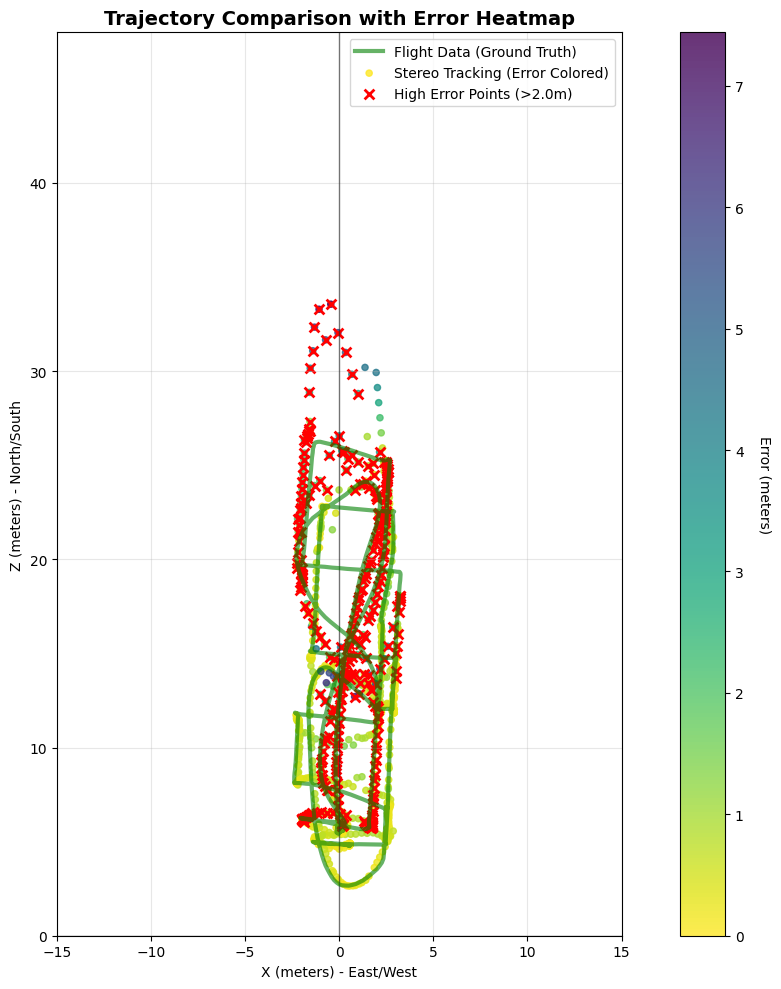

High error points: 301 out of 998 (30.2%)


In [79]:
# Trajectory with error magnitude visualization
if 'errors' in locals() and len(errors) > 0:
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Set up the plot
    ax.set_aspect('equal')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(z_min, z_max)
    ax.grid(True, alpha=0.3)
    ax.axvline(0, color='black', linewidth=1, alpha=0.5)
    ax.axhline(0, color='black', linewidth=1, alpha=0.5)
    
    # Plot flight path as base
    if flight_coords_sync:
        flight_x = [coord[0] for coord in flight_coords_sync[:min_len]]
        flight_z = [coord[1] for coord in flight_coords_sync[:min_len]]
        ax.plot(flight_x, flight_z, 'g-', linewidth=3, label='Flight Data (Ground Truth)', alpha=0.6)
    
    # Plot stereo tracking with error color mapping
    if stereo_coords_sync:
        stereo_x = [coord[0] for coord in stereo_coords_sync[:min_len]]
        stereo_z = [coord[1] for coord in stereo_coords_sync[:min_len]]
        
        # Create scatter plot with error-based colors
        scatter = ax.scatter(stereo_x, stereo_z, c=errors, cmap='viridis_r', s=20, 
                           alpha=0.8, label='Stereo Tracking (Error Colored)')
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Error (meters)', rotation=270, labelpad=20)
    
    # Mark high error points
    if 'high_error_indices' not in locals():
        high_error_indices = [i for i, e in enumerate(errors) if e > acceptable_threshold]
    
    if high_error_indices:
        high_error_x = [stereo_x[i] for i in high_error_indices]
        high_error_z = [stereo_z[i] for i in high_error_indices]
        ax.scatter(high_error_x, high_error_z, c='red', s=50, marker='x', 
                  label=f'High Error Points (>{acceptable_threshold}m)', linewidth=2)
    
    ax.set_title('Trajectory Comparison with Error Heatmap', fontsize=14, fontweight='bold')
    ax.set_xlabel('X (meters) - East/West')
    ax.set_ylabel('Z (meters) - North/South')
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    print(f"High error points: {len(high_error_indices)} out of {min_len} ({len(high_error_indices)/min_len*100:.1f}%)")
    
else:
    print("No error data available for heatmap visualization")

## 10. Error vs Distance Analysis

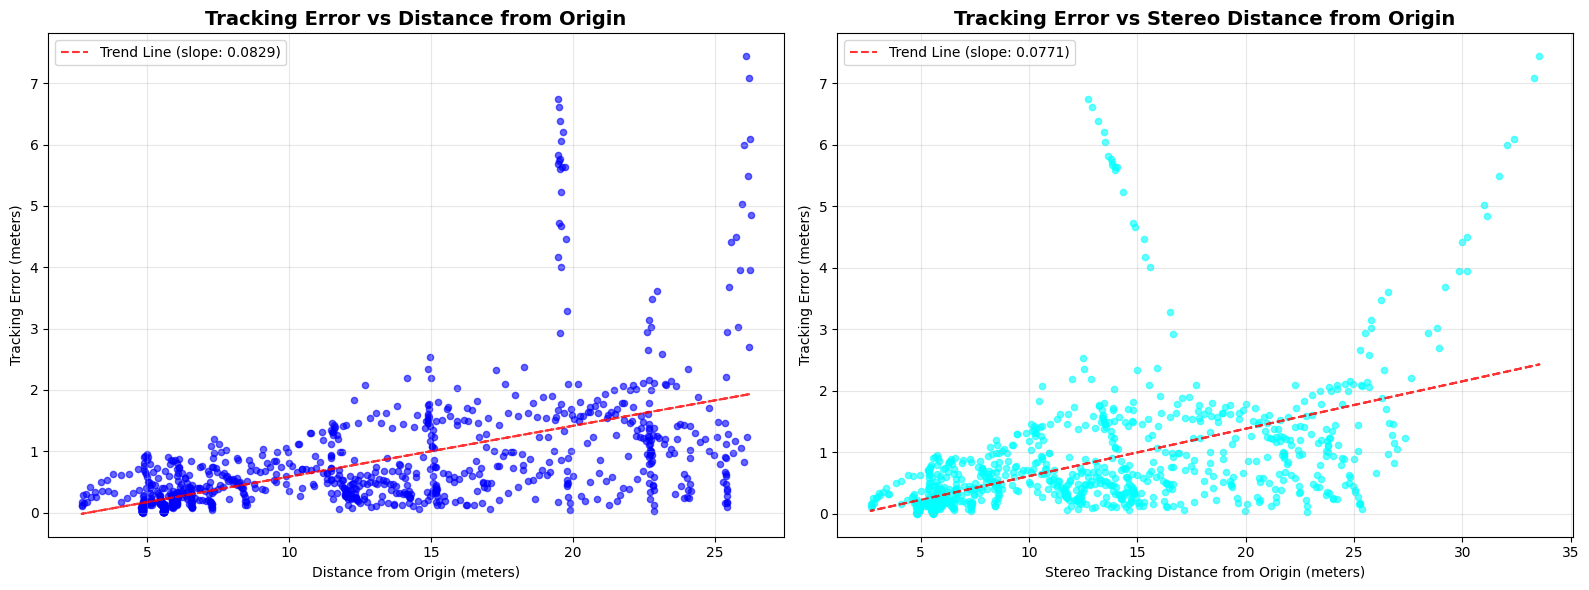

Correlation between error and flight distance from origin: 0.552
Correlation between error and stereo distance from origin: 0.516


In [80]:
# Error vs Distance from Origin Analysis
if 'errors' in locals() and len(errors) > 0 and 'flight_dist_origin' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Error vs Distance from Origin (Flight Data)
    flight_distances = flight_dist_origin[:min_len] if len(flight_dist_origin) >= min_len else flight_dist_origin
    ax1.scatter(flight_distances, errors, alpha=0.6, c='blue', s=20)
    ax1.set_title('Tracking Error vs Distance from Origin', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Distance from Origin (meters)')
    ax1.set_ylabel('Tracking Error (meters)')
    ax1.grid(True, alpha=0.3)
    
    # Add trend line
    if len(flight_distances) > 0:
        z = np.polyfit(flight_distances, errors, 1)
        p = np.poly1d(z)
        ax1.plot(flight_distances, p(flight_distances), "r--", alpha=0.8, 
                label=f'Trend Line (slope: {z[0]:.4f})')
        ax1.legend()
    
    # Error vs Stereo Distance from Origin
    stereo_distances = stereo_dist_origin[:min_len] if len(stereo_dist_origin) >= min_len else stereo_dist_origin
    ax2.scatter(stereo_distances, errors, alpha=0.6, c='cyan', s=20)
    ax2.set_title('Tracking Error vs Stereo Distance from Origin', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Stereo Tracking Distance from Origin (meters)')
    ax2.set_ylabel('Tracking Error (meters)')
    ax2.grid(True, alpha=0.3)
    
    # Add trend line
    if len(stereo_distances) > 0:
        z2 = np.polyfit(stereo_distances, errors, 1)
        p2 = np.poly1d(z2)
        ax2.plot(stereo_distances, p2(stereo_distances), "r--", alpha=0.8, 
                label=f'Trend Line (slope: {z2[0]:.4f})')
        ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation coefficients
    if len(flight_distances) > 1:
        corr_flight = np.corrcoef(flight_distances, errors)[0, 1]
        print(f"Correlation between error and flight distance from origin: {corr_flight:.3f}")
    
    if len(stereo_distances) > 1:
        corr_stereo = np.corrcoef(stereo_distances, errors)[0, 1]
        print(f"Correlation between error and stereo distance from origin: {corr_stereo:.3f}")
    
else:
    print("Error or distance data not available for analysis")

## 11. Velocity vs Distance Analysis

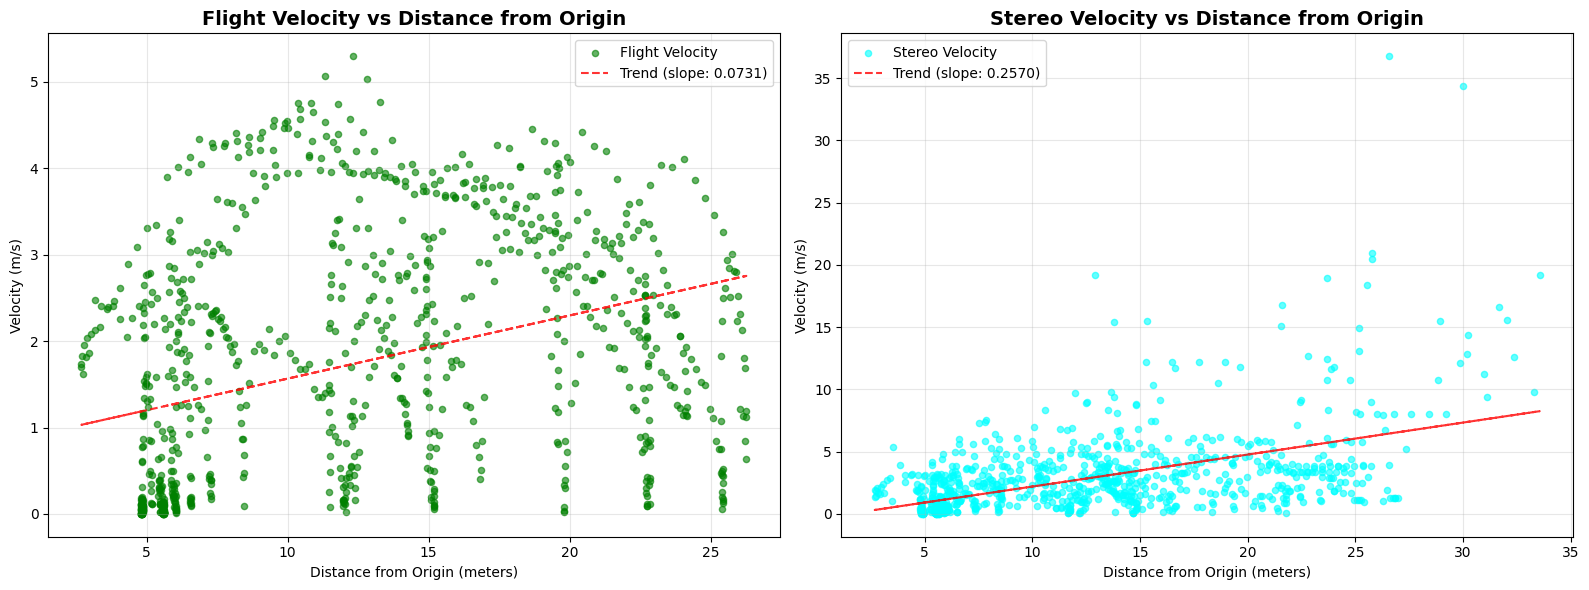

Flight: Correlation between velocity and distance from origin: 0.349
Flight: Average velocity: 1.723 m/s
Flight: Max velocity: 5.296 m/s
Stereo: Correlation between velocity and distance from origin: 0.526
Stereo: Average velocity: 2.699 m/s
Stereo: Max velocity: 36.764 m/s


In [81]:
# Velocity vs Distance from Origin Analysis
if 'flight_velocity' in locals() and 'stereo_velocity' in locals() and 'flight_dist_origin' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Flight velocity vs distance
    flight_dist_vel = flight_dist_origin[1:len(flight_velocity)+1] if len(flight_dist_origin) > len(flight_velocity) else flight_dist_origin[:len(flight_velocity)]
    ax1.scatter(flight_dist_vel, flight_velocity, alpha=0.6, c='green', s=20, label='Flight Velocity')
    ax1.set_title('Flight Velocity vs Distance from Origin', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Distance from Origin (meters)')
    ax1.set_ylabel('Velocity (m/s)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Add trend line
    if len(flight_dist_vel) > 1:
        z_flight = np.polyfit(flight_dist_vel, flight_velocity, 1)
        p_flight = np.poly1d(z_flight)
        ax1.plot(flight_dist_vel, p_flight(flight_dist_vel), "r--", alpha=0.8, 
                label=f'Trend (slope: {z_flight[0]:.4f})')
        ax1.legend()
    
    # Stereo velocity vs distance
    stereo_dist_vel = stereo_dist_origin[1:len(stereo_velocity)+1] if len(stereo_dist_origin) > len(stereo_velocity) else stereo_dist_origin[:len(stereo_velocity)]
    ax2.scatter(stereo_dist_vel, stereo_velocity, alpha=0.6, c='cyan', s=20, label='Stereo Velocity')
    ax2.set_title('Stereo Velocity vs Distance from Origin', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Distance from Origin (meters)')
    ax2.set_ylabel('Velocity (m/s)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Add trend line
    if len(stereo_dist_vel) > 1:
        z_stereo = np.polyfit(stereo_dist_vel, stereo_velocity, 1)
        p_stereo = np.poly1d(z_stereo)
        ax2.plot(stereo_dist_vel, p_stereo(stereo_dist_vel), "r--", alpha=0.8, 
                label=f'Trend (slope: {z_stereo[0]:.4f})')
        ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate statistics
    if len(flight_dist_vel) > 1:
        corr_flight_vel = np.corrcoef(flight_dist_vel, flight_velocity)[0, 1]
        print(f"Flight: Correlation between velocity and distance from origin: {corr_flight_vel:.3f}")
        print(f"Flight: Average velocity: {np.mean(flight_velocity):.3f} m/s")
        print(f"Flight: Max velocity: {np.max(flight_velocity):.3f} m/s")
    
    if len(stereo_dist_vel) > 1:
        corr_stereo_vel = np.corrcoef(stereo_dist_vel, stereo_velocity)[0, 1]
        print(f"Stereo: Correlation between velocity and distance from origin: {corr_stereo_vel:.3f}")
        print(f"Stereo: Average velocity: {np.mean(stereo_velocity):.3f} m/s")
        print(f"Stereo: Max velocity: {np.max(stereo_velocity):.3f} m/s")
    
else:
    print("Velocity or distance data not available for analysis")

## 12. Temporal Error Patterns

C:\Users\farya\AppData\Local\Temp\ipykernel_37912\1264809064.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(period_errors, labels=periods)


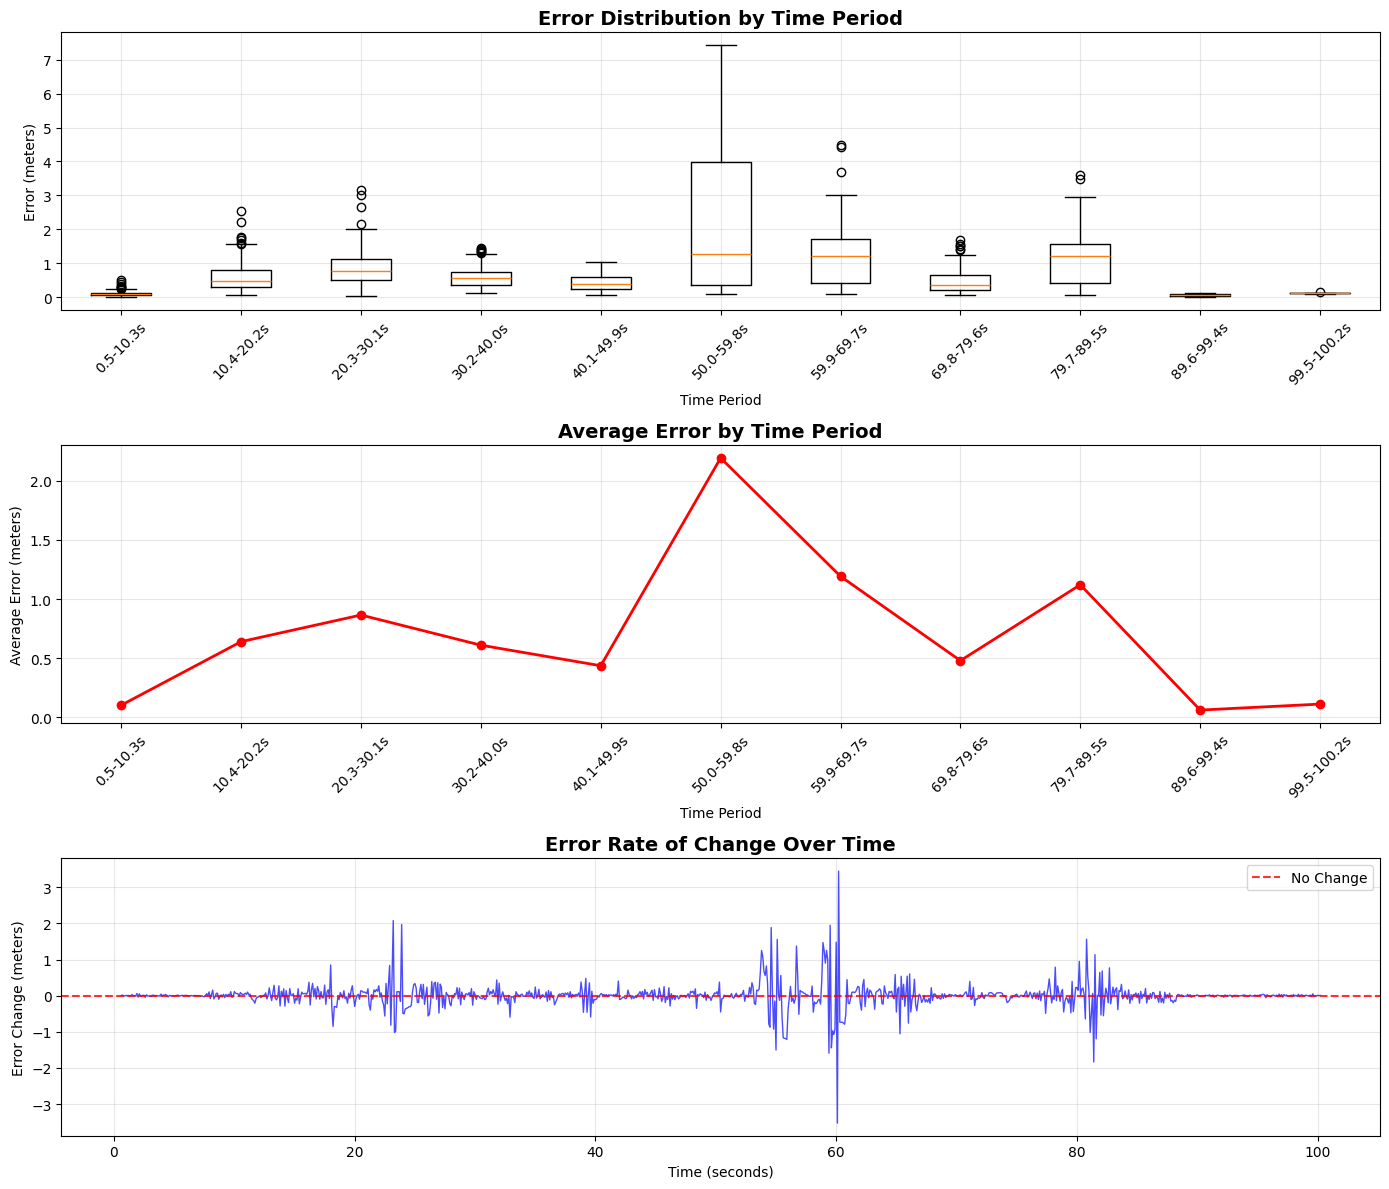

Temporal Error Analysis:
Total analysis duration: 99.7s
Number of time periods: 11
Best performing period: 89.6-99.4s (avg error: 0.061m)
Worst performing period: 50.0-59.8s (avg error: 2.192m)
Error trend: Stable over time (slope: -0.0091)
Error volatility across periods: 0.597m


In [83]:
# Temporal Error Pattern Analysis
if 'errors' in locals() and len(errors) > 0 and timestamps_sec is not None:
    # Analyze error patterns over time periods
    total_duration = timestamps_sec[-1] - timestamps_sec[0]
    step = int(len(errors) / 10)  # Divide into 10 time periods
    
    periods = []
    period_errors = []
    
    for i in range(0, len(errors), step):
        end_idx = min(i + step, len(errors))
        current_period = errors[i:end_idx]
        if len(current_period) > 0:
            periods.append(f"{timestamps_sec[i]:.1f}-{timestamps_sec[end_idx-1]:.1f}s")
            period_errors.append(current_period)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))
    
    # Box plot of errors by time period
    ax1.boxplot(period_errors, labels=periods)
    ax1.set_title('Error Distribution by Time Period', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Time Period')
    ax1.set_ylabel('Error (meters)')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Average error per time period
    avg_errors_per_period = [np.mean(period) for period in period_errors]
    period_centers = range(len(periods))
    
    ax2.plot(period_centers, avg_errors_per_period, 'ro-', linewidth=2, markersize=6)
    ax2.set_title('Average Error by Time Period', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Time Period')
    ax2.set_ylabel('Average Error (meters)')
    ax2.set_xticks(period_centers)
    ax2.set_xticklabels(periods, rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Error rate of change
    error_rate_change = np.diff(errors)
    ax3.plot(timestamps_sec[1:len(error_rate_change)+1], error_rate_change, 'b-', alpha=0.7, linewidth=1)
    ax3.axhline(0, color='red', linestyle='--', alpha=0.8, label='No Change')
    ax3.set_title('Error Rate of Change Over Time', fontsize=14, fontweight='bold')
    ax3.set_xlabel(time_label)
    ax3.set_ylabel('Error Change (meters)')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis of time periods
    print("Temporal Error Analysis:")
    print(f"Total analysis duration: {total_duration:.1f}s")
    print(f"Number of time periods: {len(periods)}")
    
    # Find best and worst periods
    max_error_period = np.argmax(avg_errors_per_period)
    min_error_period = np.argmin(avg_errors_per_period)
    
    print(f"Best performing period: {periods[min_error_period]} (avg error: {avg_errors_per_period[min_error_period]:.3f}m)")
    print(f"Worst performing period: {periods[max_error_period]} (avg error: {avg_errors_per_period[max_error_period]:.3f}m)")
    
    # Error trend analysis
    error_trend_slope = np.polyfit(range(len(avg_errors_per_period)), avg_errors_per_period, 1)[0]
    if error_trend_slope > 0.01:
        print(f"Error trend: Increasing over time (slope: {error_trend_slope:.4f})")
    elif error_trend_slope < -0.01:
        print(f"Error trend: Decreasing over time (slope: {error_trend_slope:.4f})")
    else:
        print(f"Error trend: Stable over time (slope: {error_trend_slope:.4f})")
    
    # Error volatility
    error_volatility = np.std(avg_errors_per_period)
    print(f"Error volatility across periods: {error_volatility:.3f}m")
    
else:
    print("Error or time data not available for temporal analysis")

## 13. Comprehensive Performance Dashboard

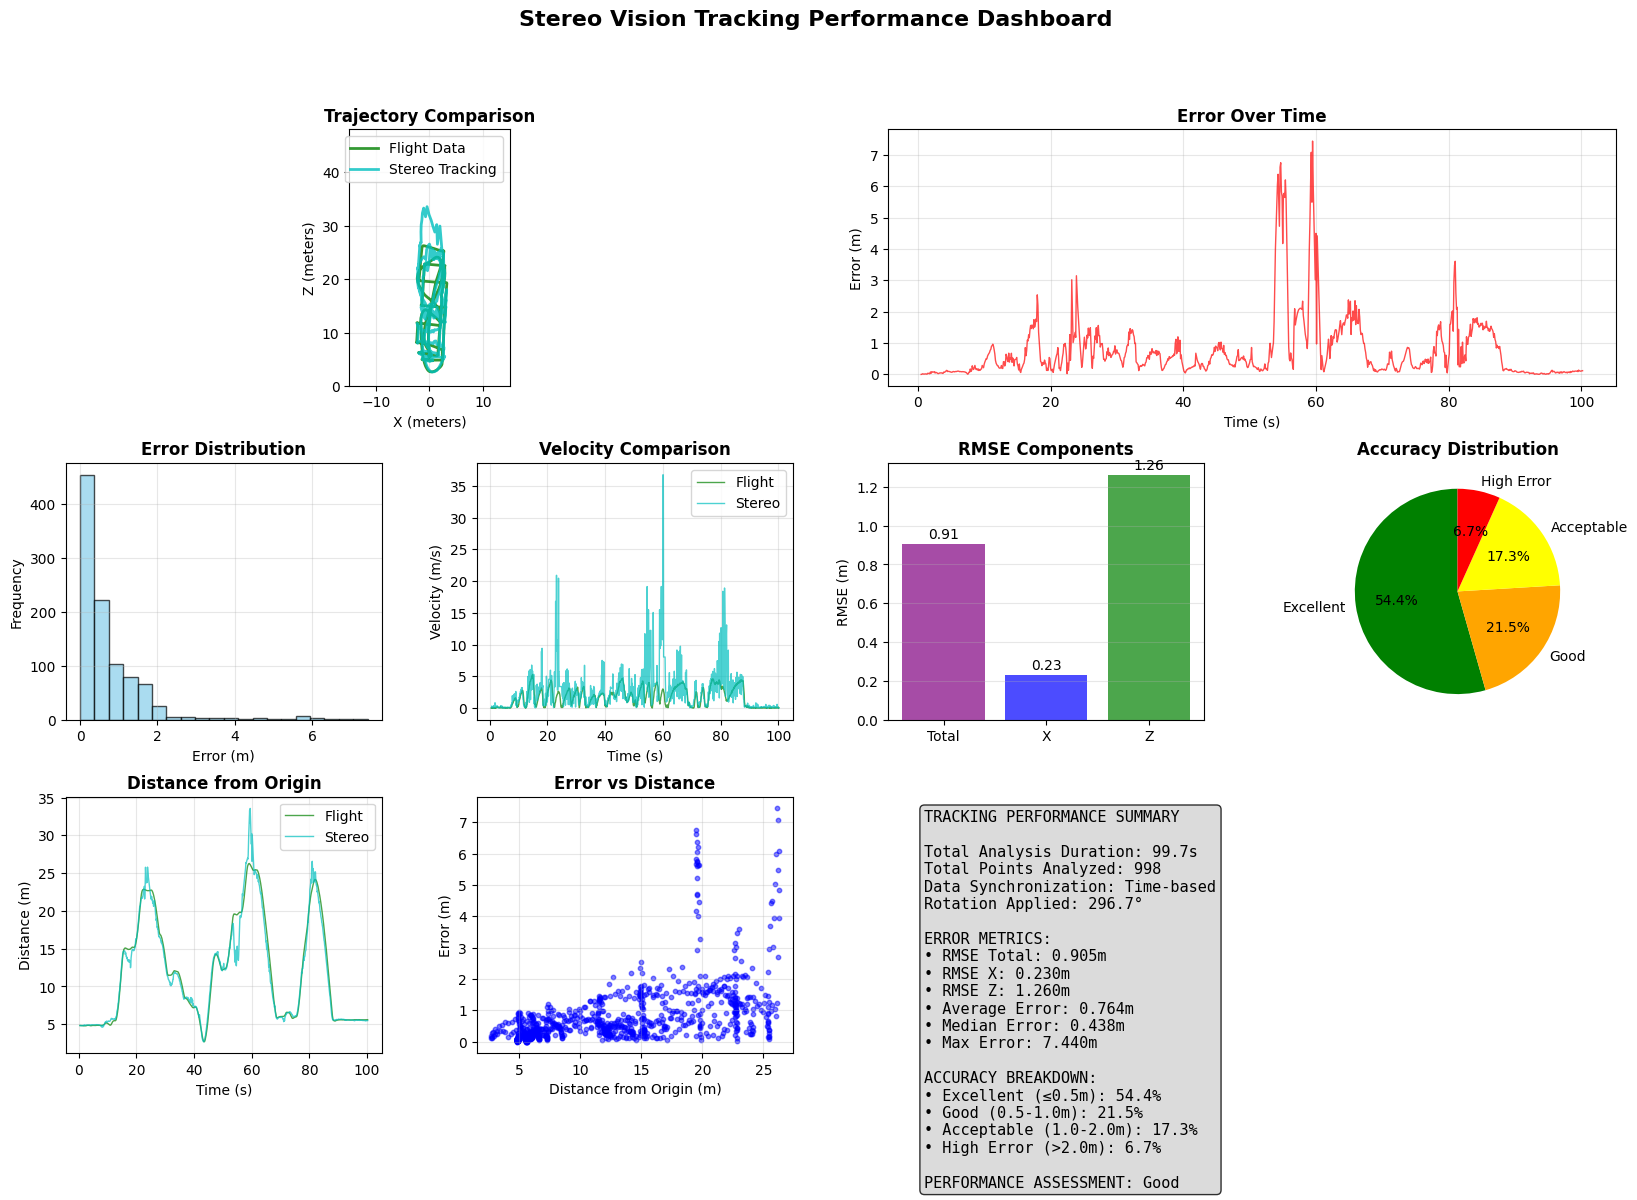

In [84]:
# Comprehensive Performance Dashboard
if 'errors' in locals() and 'flight_velocity' in locals():
    fig = plt.figure(figsize=(20, 12))
    
    # Create a 3x4 grid of subplots
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # 1. Trajectory comparison (top left, spans 2 columns)
    ax1 = fig.add_subplot(gs[0, :2])
    ax1.set_aspect('equal')
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(z_min, z_max)
    ax1.grid(True, alpha=0.3)
    
    if flight_coords_sync:
        flight_x = [coord[0] for coord in flight_coords_sync]
        flight_z = [coord[1] for coord in flight_coords_sync]
        ax1.plot(flight_x, flight_z, 'g-', linewidth=2, label='Flight Data', alpha=0.8)
    
    if stereo_coords_sync:
        stereo_x = [coord[0] for coord in stereo_coords_sync]
        stereo_z = [coord[1] for coord in stereo_coords_sync]
        ax1.plot(stereo_x, stereo_z, 'c-', linewidth=2, label='Stereo Tracking', alpha=0.8)
    
    ax1.set_title('Trajectory Comparison', fontsize=12, fontweight='bold')
    ax1.set_xlabel('X (meters)')
    ax1.set_ylabel('Z (meters)')
    ax1.legend()
    
    # 2. Error over time (top right, spans 2 columns)
    ax2 = fig.add_subplot(gs[0, 2:])
    error_time = timestamps_sec[:len(errors)] if timestamps_sec is not None else np.linspace(0, len(errors) * 0.1, len(errors))
    ax2.plot(error_time, errors, 'r-', linewidth=1, alpha=0.7)
    ax2.set_title('Error Over Time', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Error (m)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Error histogram (middle left)
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.hist(errors, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.set_title('Error Distribution', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Error (m)')
    ax3.set_ylabel('Frequency')
    ax3.grid(True, alpha=0.3)
    
    # 4. Velocity comparison (middle center)
    ax4 = fig.add_subplot(gs[1, 1])
    time_vel = timestamps_sec[1:len(flight_velocity)+1] if timestamps_sec is not None else np.arange(len(flight_velocity)) * 0.1
    ax4.plot(time_vel, flight_velocity, 'g-', linewidth=1, label='Flight', alpha=0.7)
    ax4.plot(time_vel[:len(stereo_velocity)], stereo_velocity, 'c-', linewidth=1, label='Stereo', alpha=0.7)
    ax4.set_title('Velocity Comparison', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Velocity (m/s)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. RMSE components (middle right)
    ax5 = fig.add_subplot(gs[1, 2])
    rmse_labels = ['Total', 'X', 'Z']
    rmse_vals = [rmse, x_rmse, z_rmse] if 'rmse' in locals() else [0, 0, 0]
    bars = ax5.bar(rmse_labels, rmse_vals, color=['purple', 'blue', 'green'], alpha=0.7)
    ax5.set_title('RMSE Components', fontsize=12, fontweight='bold')
    ax5.set_ylabel('RMSE (m)')
    ax5.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars, rmse_vals):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(rmse_vals) * 0.01, 
                f'{val:.2f}', ha='center', va='bottom', fontsize=10)
    
    # 6. Accuracy categories (middle far right)
    ax6 = fig.add_subplot(gs[1, 3])
    if 'excellent_pct' in locals():
        acc_labels = ['Excellent', 'Good', 'Acceptable', 'High Error']
        high_error_pct = high_error_threshold
        acc_values = [excellent_pct, good_pct, acceptable_pct, high_error_pct]
        colors = ['green', 'orange', 'yellow', 'red']
        ax6.pie(acc_values, labels=acc_labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax6.set_title('Accuracy Distribution', fontsize=12, fontweight='bold')
    
    # 7. Distance from origin (bottom left)
    ax7 = fig.add_subplot(gs[2, 0])
    if 'flight_dist_origin' in locals():
        time_dist = timestamps_sec[:len(flight_dist_origin)] if timestamps_sec is not None else np.linspace(0, len(flight_dist_origin) * 0.1, len(flight_dist_origin))
        ax7.plot(time_dist, flight_dist_origin, 'g-', linewidth=1, label='Flight', alpha=0.7)
        ax7.plot(time_dist[:len(stereo_dist_origin)], stereo_dist_origin, 'c-', linewidth=1, label='Stereo', alpha=0.7)
        ax7.set_title('Distance from Origin', fontsize=12, fontweight='bold')
        ax7.set_xlabel('Time (s)')
        ax7.set_ylabel('Distance (m)')
        ax7.legend()
        ax7.grid(True, alpha=0.3)
    
    # 8. Error vs distance scatter (bottom center)
    ax8 = fig.add_subplot(gs[2, 1])
    if 'flight_dist_origin' in locals():
        flight_distances = flight_dist_origin[:len(errors)]
        ax8.scatter(flight_distances, errors, alpha=0.5, s=10, c='blue')
        ax8.set_title('Error vs Distance', fontsize=12, fontweight='bold')
        ax8.set_xlabel('Distance from Origin (m)')
        ax8.set_ylabel('Error (m)')
        ax8.grid(True, alpha=0.3)
    
    # 9. Summary statistics (bottom right, spans 2 columns)
    ax9 = fig.add_subplot(gs[2, 2:])
    ax9.axis('off')
    
    # Create summary text
    summary_text = f"""TRACKING PERFORMANCE SUMMARY
    
Total Analysis Duration: {comparison_duration:.1f}s
Total Points Analyzed: {len(errors)}
Data Synchronization: Time-based
Rotation Applied: {ROTATION_DEGREES}°

ERROR METRICS:
• RMSE Total: {rmse:.3f}m
• RMSE X: {x_rmse:.3f}m  
• RMSE Z: {z_rmse:.3f}m
• Average Error: {avg_error:.3f}m
• Median Error: {median_error:.3f}m
• Max Error: {max_error:.3f}m

ACCURACY BREAKDOWN:
• Excellent (≤0.5m): {excellent_pct:.1f}%
• Good (0.5-1.0m): {good_pct:.1f}%
• Acceptable (1.0-2.0m): {acceptable_pct:.1f}%
• High Error (>2.0m): {high_error_pct:.1f}%

PERFORMANCE ASSESSMENT: {assessment}"""
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=11, 
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.suptitle('Stereo Vision Tracking Performance Dashboard', fontsize=16, fontweight='bold', y=0.98)
    plt.show()
    
else:
    print("Insufficient data for comprehensive dashboard")